# 🪄 옵티마이저

### 📥 Import

In [14]:
import os
import sys
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Thanks to **dhaitz**!
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# 한글폰트 설정
import matplotlib as mpl
mpl.rc('font', family='D2Coding')
mpl.rcParams['axes.unicode_minus'] = False

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
print(f'현재 작업 디렉토리: "{os.getcwd()}"')

from common.functions import *
from common.gradient import numerical_gradient
from common.layers import *
from common.multi_layer_net import MultiLayerNet
from common.util import smooth_curve
from dataset.mnist import load_mnist

현재 작업 디렉토리: "g:\zer0ken\ms-ai-school\neural-net\ch05 학습 기술"


### 🔮 확률적 경사 하강법
SGD: Stochastic Gradient Discent

In [15]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

### 🛝 모멘텀
Momentum

In [16]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {k: np.zeros_like(v) for k, v in params.items()}
        
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

### 🦎 AdaGrad
AdaGrad: Adaptive Gradient Algorithm

In [17]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {k: np.zeros_like(v) for k, v in params.items()}
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### 🤖 Adam
Adam: Adaptive Moment Estimation

In [18]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

### 🪄 임의의 함수에 대한 매개변수 최적화

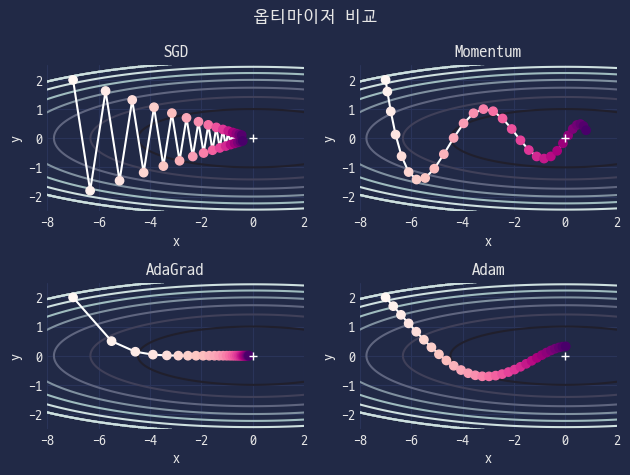

In [19]:
def f(x, y):
    return x ** 2 / 20.0 + y ** 2


def df(x, y):
    return x / 10.0, 2.0 * y


init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos
grads = {'x': 0, 'y': 0}

optimizers = {
    'SGD': SGD(lr=0.95),
    'Momentum': Momentum(lr=0.1),
    'AdaGrad': AdaGrad(lr=1.5),
    'Adam': Adam(lr=0.3)
}

idx = 1

for optimizer_name, optimizer in optimizers.items():
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    
    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    
    mask = Z > 7
    Z[mask] = 0
    
    plt.subplot(2, 2, idx)
    idx += 1
    
    plt.contour(X, Y, Z, cmap=plt.cm.bone)
    plt.plot(x_history, y_history, '-w')
    
    c = list(range(len(x_history)))
    plt.scatter(x_history, y_history, c=c, zorder=2, marker='o')
    
    plt.ylim(-2.5, 2.5)
    plt.xlim(-8, 2)
    plt.plot(0, 0, '+w')
    plt.title(optimizer_name)
    plt.xlabel('x')
    plt.ylabel('y')
    
plt.suptitle('옵티마이저 비교')
plt.tight_layout()
plt.show()

### ✍️ MNIST 데이터셋에 대한 매개변수 최적화

In [20]:
"""
0. MNIST 데이터셋 불러오기
"""
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iter = 10000

"""
1. 실험용 설정
"""
optimizers = {
    'SGD': SGD(),
    'Momentum': Momentum(),
    'AdaGrad': AdaGrad(),
    'Adam': Adam()
}

networks = {}
train_loss = {}
for optimizer_name in optimizers:
    networks[optimizer_name] = MultiLayerNet(
        input_size=784,
        hidden_size_list=[100, 100, 100, 100],
        output_size=10
    )
    train_loss[optimizer_name] = []

"""
2. 훈련
"""
for i in range(max_iter + 1):
    if i < max_iter:
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
        
        for optimizer_name, optimizer in optimizers.items():
            network = networks[optimizer_name]
            grads = network.gradient(x_batch, t_batch)
            optimizer.update(network.params, grads)
            loss = networks[optimizer_name].loss(x_batch, t_batch)
            train_loss[optimizer_name].append(loss)
    
    if i % 1000 == 0:
        clear_output()
        print(f'#{i} Iteration')
        
        for optimizer_name in optimizers:
            loss = networks[optimizer_name].loss(x_batch, t_batch)
            print(f'{optimizer_name:8}: {loss=:.6f}')

#10000 Iteration
SGD     : loss=0.071580
Momentum: loss=0.004123
AdaGrad : loss=0.002593
Adam    : loss=0.003195


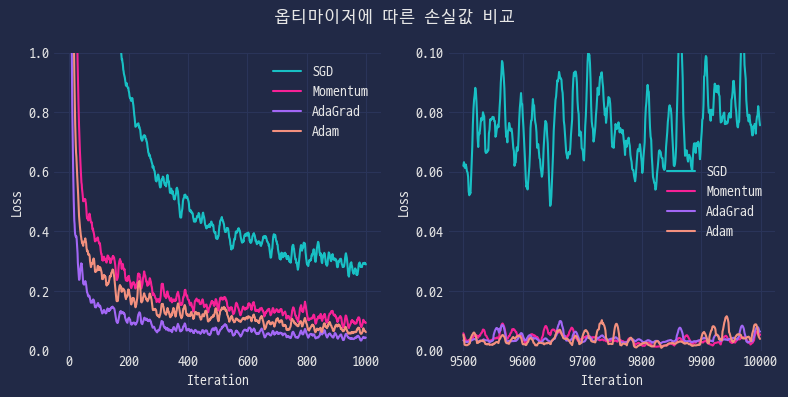

In [38]:
"""
3. 그래프
"""
x = np.arange(max_iter)
y = {optimizer_name: smooth_curve(train_loss[optimizer_name]) for optimizer_name in optimizers}

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
for optimizer_name in optimizers:
    plt.plot(x[:1000], y[optimizer_name][:1000],label=optimizer_name)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()

plt.subplot(1, 2, 2)
for optimizer_name in optimizers:
    plt.plot(x[-500:], y[optimizer_name][-500:],label=optimizer_name)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.ylim(0, 0.1)
plt.legend()

plt.suptitle('옵티마이저에 따른 손실값 비교')
plt.tight_layout()
plt.show()